# Imports

In [1]:
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

# Parameters

In [2]:
dirname = "../../data/datasets/jasper_ridge"
basename = "jasper_ridge.npz"

# Function Definitions

In [3]:
def get_masked_spectrum(spectrum, spectral_bands, selected_bands):
    is_1d = len(spectrum.shape) == 1
    if is_1d:
        spectrum = np.expand_dims(spectrum, 0)
    mask = np.ones( (len(spectrum),len(spectral_bands)-1) )
    mask[:,selected_bands - 1] = 0
    masked_spectrum = np.zeros( (len(spectrum),len(spectral_bands)-1) )
    masked_spectrum[:,selected_bands - 1] = spectrum
    masked_spectrum = np.ma.array(masked_spectrum, mask=mask)
    if is_1d:
        masked_spectrum = masked_spectrum[0]
    return masked_spectrum

# Data Loading

In [4]:
filename = os.path.join(dirname, basename)

with np.load(filename) as npz_data:
    print(npz_data.keys())
    hsi_data = npz_data["hsi_data"]
    endmembers = npz_data["endmembers"]
    abundance_maps = npz_data["abundance_maps"]
    labels = npz_data["labels"]
    colors = npz_data["colors"]
    spectral_bands = npz_data["spectral_bands"]
    selected_bands = npz_data["selected_bands"]
    resolution = npz_data["resolution"]

print(f"          hsi_data: {hsi_data.shape}")
print(f"        endmembers: {endmembers.shape}")
print(f"    abundance_maps: {abundance_maps.shape}")
print(f"    spectral_bands: {spectral_bands.shape}")
print(f"    selected_bands: {selected_bands.shape}")
print(f"        resolution: {resolution}")
print(f"            labels: {labels}")
print(f"            colors: {colors}")

KeysView(NpzFile '../../data/datasets/jasper_ridge/jasper_ridge.npz' with keys: hsi_data, endmembers, abundance_maps, labels, colors...)
          hsi_data: (100, 100, 198)
        endmembers: (4, 198)
    abundance_maps: (100, 100, 4)
    spectral_bands: (225,)
    selected_bands: (198,)
        resolution: nm
            labels: ['Trees' 'Water' 'Soil' 'Road']
            colors: ['forestgreen' 'royalblue' 'saddlebrown' 'dimgray']


# Data Visualizations

In [5]:
xx = (spectral_bands[1:] + spectral_bands[:-1]) / 2
masked_endmembers = get_masked_spectrum(endmembers, spectral_bands, selected_bands)

## HSI Data

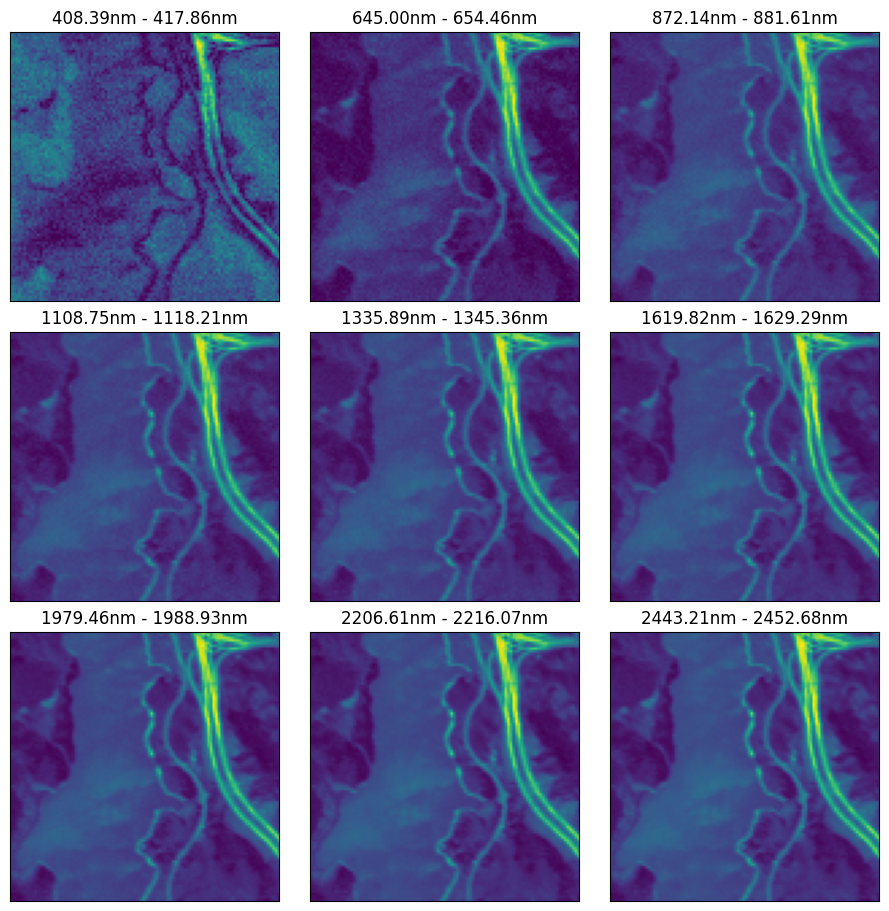

In [6]:
n_rows = 3
n_cols = 3
idx = np.round(np.linspace(0, hsi_data.shape[-1]-1, n_rows*n_cols)).astype(int)

fig = plt.figure(constrained_layout=True, figsize=(3*n_cols,3*n_rows))
gs = mpl.gridspec.GridSpec(
    nrows=n_rows,
    ncols=n_cols,
    figure=fig
)
for hsi_idx,band_idx in enumerate(idx):
    tmp_idx = selected_bands[band_idx]-1
    band_start,band_end = spectral_bands[tmp_idx:tmp_idx+2]
    ax = fig.add_subplot(gs[hsi_idx])
    ax.imshow(hsi_data[:,:,hsi_idx])
    ax.set_title(f"{band_start:0.2f}{resolution} - {band_end:0.2f}{resolution}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
    

## Endmembers

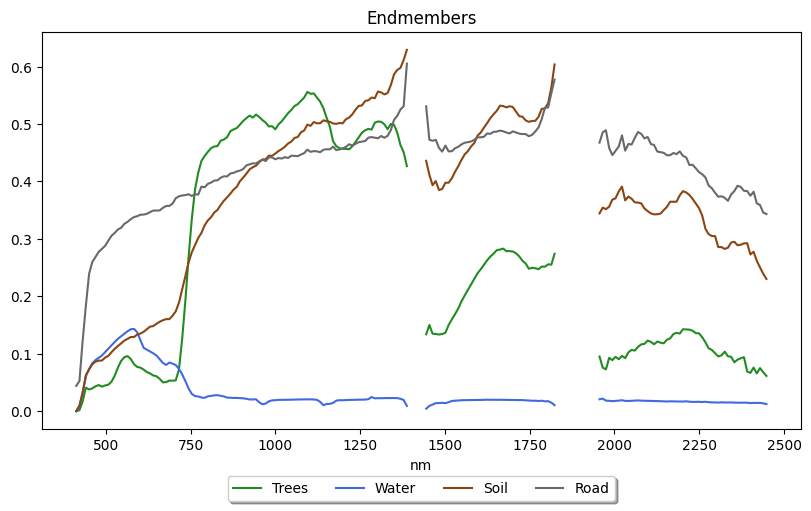

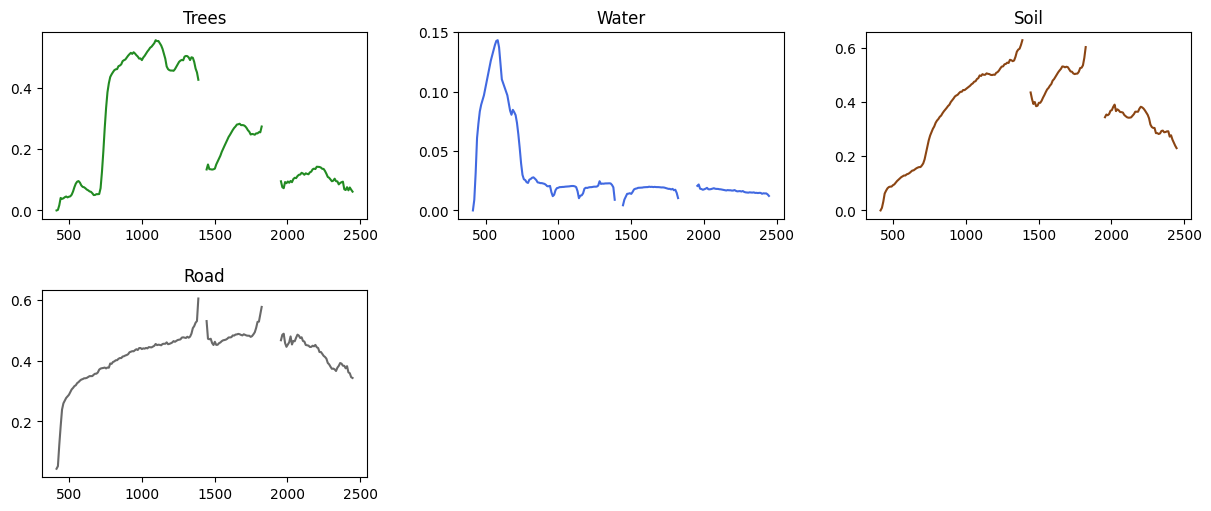

In [7]:
n_cols = 3
n_rows = int(np.ceil(len(endmembers)/n_cols))

fig,ax = plt.subplots(constrained_layout=True, figsize=(8,5))
for ii,endmember in enumerate(masked_endmembers):
    ax.plot(xx, endmember, label=labels[ii], color=colors[ii])
ax.set_title("Endmembers")
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.1),
    fancybox=True, shadow=True, ncol=5
)
ax.set_xlabel(resolution)
plt.show()

fig = plt.figure(constrained_layout=True, figsize=(8/2*n_cols,5/2*n_rows))
gs = mpl.gridspec.GridSpec(
    nrows=n_rows,
    ncols=n_cols,
    wspace=0.1,
    hspace=0.1,
    figure=fig
)
for ii,endmember in enumerate(endmembers):
    yy = get_masked_spectrum(endmember, spectral_bands, selected_bands)
    ax = fig.add_subplot(gs[ii])
    ax.plot(xx, yy, color=colors[ii])
    ax.set_title(labels[ii])
plt.show()

## Abundances

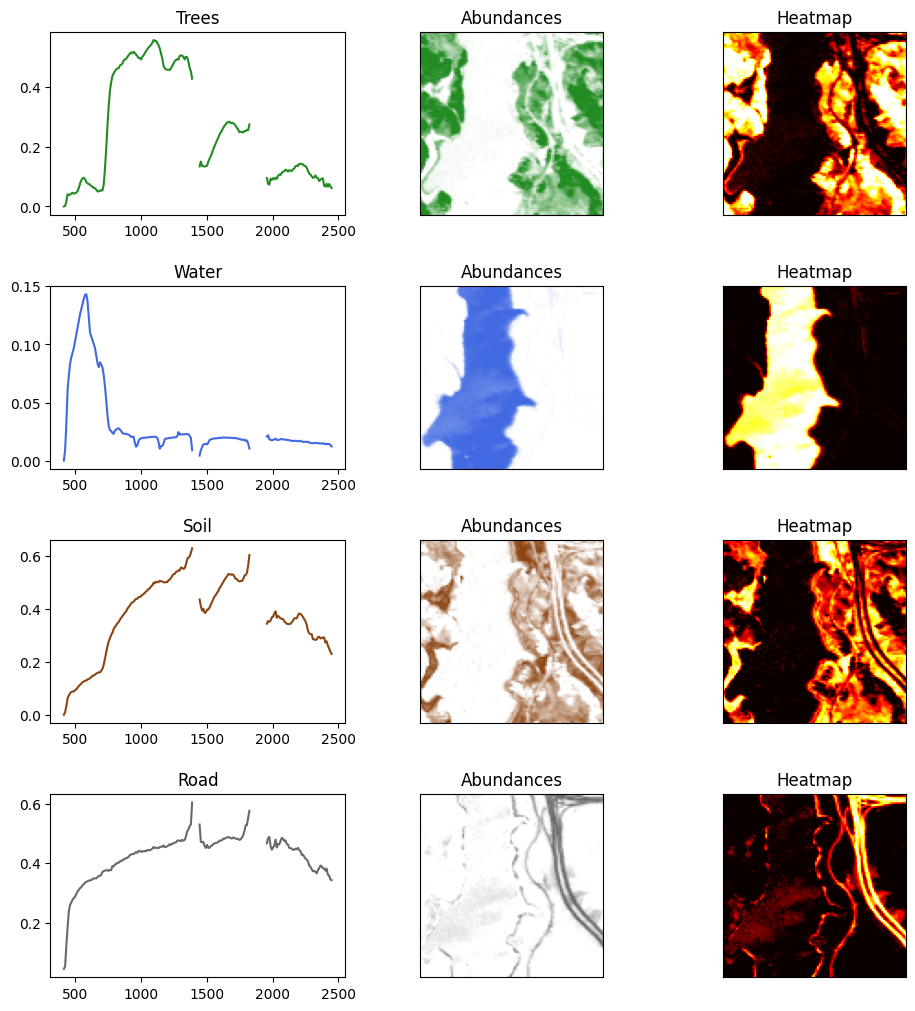

In [8]:
n_rows = len(endmembers)
n_cols = 3

fig = plt.figure(constrained_layout=True, figsize=(8/2.5*n_cols,5/2*n_rows))
gs = mpl.gridspec.GridSpec(
    nrows=n_rows,
    ncols=n_cols,
    hspace=0.1,
    figure=fig
)

for ii in range(len(endmembers)):
    cmap = mpl.colors.LinearSegmentedColormap.from_list(colors[ii], ["white", colors[ii]])

    ax = fig.add_subplot(gs[n_cols*ii+0])
    ax.plot(xx, masked_endmembers[ii], color=colors[ii])
    ax.set_title(labels[ii])
    
    ax = fig.add_subplot(gs[n_cols*ii+1])
    ax.imshow(abundance_maps[:,:,ii], cmap=cmap, vmin=0, vmax=1)
    ax.set_title("Abundances")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = fig.add_subplot(gs[n_cols*ii+2])
    ax.imshow(abundance_maps[:,:,ii], cmap="hot", vmin=0, vmax=1)
    ax.set_title("Heatmap")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Pure Pixel Samples

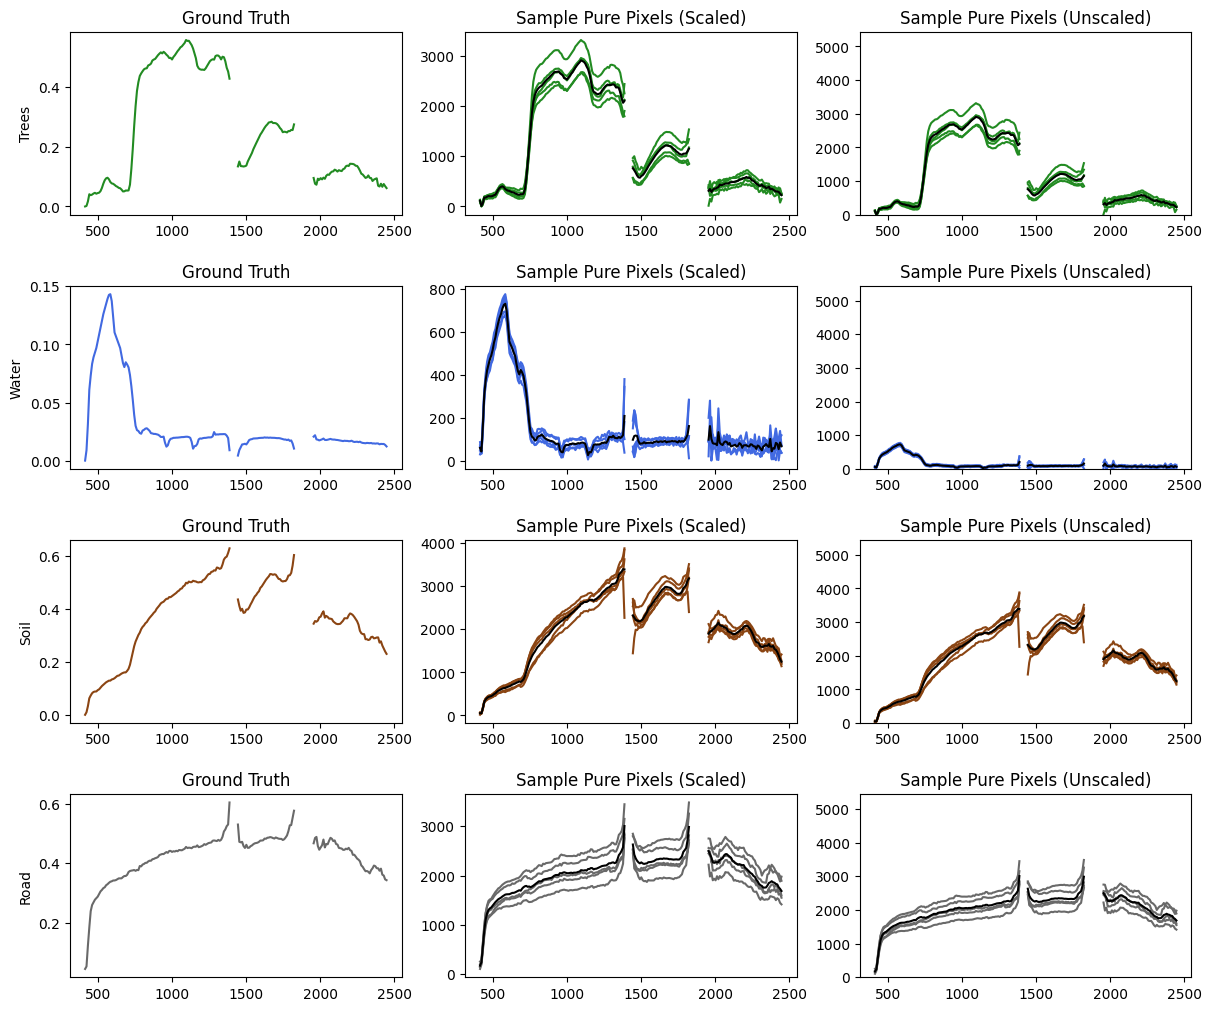

In [9]:
n_samples = 5

n_rows=len(endmembers)
n_cols=3

fig = plt.figure(constrained_layout=True, figsize=(8/2*n_cols,5/2*n_rows))
gs = mpl.gridspec.GridSpec(
    nrows=len(endmembers),
    ncols=n_cols,
    hspace=0.1,
    figure=fig
)

hsi_data_2d = hsi_data.reshape( (-1,hsi_data.shape[2]) )
vmin, vmax = hsi_data_2d.min(), hsi_data_2d.max()
for ii in range(len(endmembers)):
    is_pure = np.isclose(abundance_maps[:,:,ii], 1).flatten()
    pure_pixels = hsi_data_2d[is_pure]
    max_values = pure_pixels.max(axis=1)
    sorted_idx = np.argsort(max_values)
    idx = np.round(np.linspace(0, len(sorted_idx)-1, n_samples)).astype(int)
    masked_pure_pixels = get_masked_spectrum(pure_pixels, spectral_bands, selected_bands)

    ax = fig.add_subplot(gs[n_cols*ii+0])
    ax.plot(xx, masked_endmembers[ii], color=colors[ii])
    ax.set_ylabel(labels[ii])
    ax.set_title("Ground Truth")
    
    ax = fig.add_subplot(gs[n_cols*ii+1])
    ax.plot(xx, masked_pure_pixels[idx].T, color=colors[ii], zorder=0)
    ax.plot(xx, np.mean(masked_pure_pixels[idx], axis=0).T, color="black", zorder=1)
    ax.set_title("Sample Pure Pixels (Scaled)")
    
    ax = fig.add_subplot(gs[n_cols*ii+2])
    ax.plot(xx, masked_pure_pixels[idx].T, color=colors[ii], zorder=0)
    ax.plot(xx, np.mean(masked_pure_pixels[idx], axis=0).T, color="black", zorder=1)
    ax.set_title("Sample Pure Pixels (Unscaled)")
    ax.set_ylim(vmin, vmax)
plt.show()

## Maximum Abundance Map

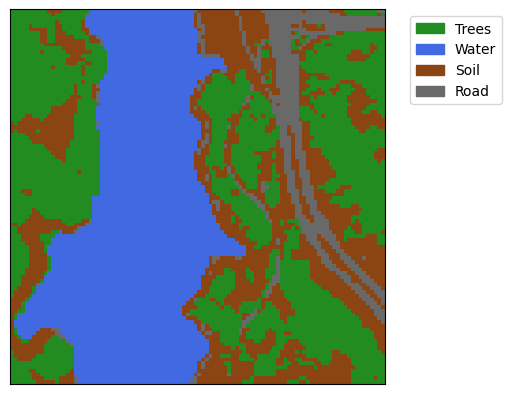

In [10]:
listed_colors = mpl.colors.ListedColormap(colors)

fig,ax = plt.subplots(constrained_layout=True, figsize=(5,5))
ax.matshow(np.argmax(abundance_maps, axis=2), cmap=listed_colors)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.legend(
    handles=[mpl.patches.Patch(color=color, label=label) for color,label in zip(colors,labels)],
    bbox_to_anchor=(1.05, 1), loc=2
)
plt.show()

## Averaged Abundance Map

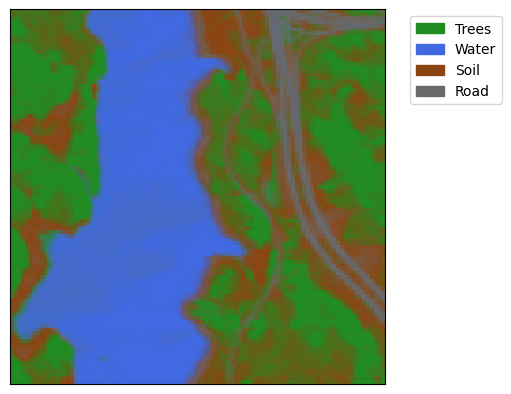

In [11]:
rgb_colors = np.asarray([mpl.colors.to_rgb(color) for color in colors])

abundance_maps_2d = abundance_maps.reshape( (-1, len(endmembers)) )
rgb_image = np.matmul(
    abundance_maps_2d, rgb_colors
).reshape( abundance_maps.shape[:-1]+(3,) )

fig,ax = plt.subplots(constrained_layout=True, figsize=(5,5))
ax.matshow(rgb_image)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.legend(
    handles=[mpl.patches.Patch(color=color, label=label) for color,label in zip(colors,labels)],
    bbox_to_anchor=(1.05, 1), loc=2
)
plt.show()